In [1]:
import time
import pandas as pd
import seaborn as sns
from functools import reduce

import torch
import pyro
import pyro.distributions as dist
import pyro.ops.stats as stats

from utils import sample_binomial, posterior_predictive_binomial

pyro.set_rng_seed(100)

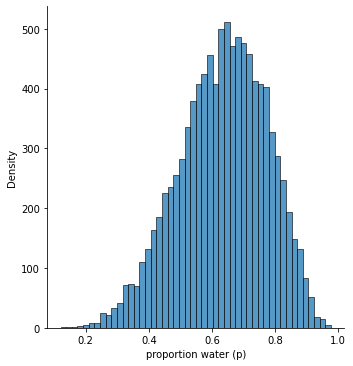

In [2]:
# Easy

samples = sample_binomial(n=9, k=6, n_steps=1000, n_samples=10000)
ax = sns.displot(samples)
ax.set(xlabel="proportion water (p)", ylabel="Density");

In [3]:
# 3E1

sum(samples < 0.2) / 1e4

tensor(0.0010)

In [4]:
# 3E2

sum(samples > 0.8) / 1e4

tensor(0.1166)

In [5]:
# 3E3

sum((samples > 0.2) & (samples < 0.8)) / 1e4

tensor(0.8824)

In [6]:
# 3E4

stats.quantile(samples, 0.2)

tensor(0.5155)

In [7]:
# 3E5

stats.quantile(samples, 0.8)

tensor(0.7588)

In [8]:
# 3E6

stats.hpdi(samples, prob=0.66)

tensor([0.5155, 0.7858])

In [9]:
# 3E7

print(stats.quantile(samples, 0.17))
print(stats.quantile(samples, 0.83))

tensor(0.4965)
tensor(0.7718)


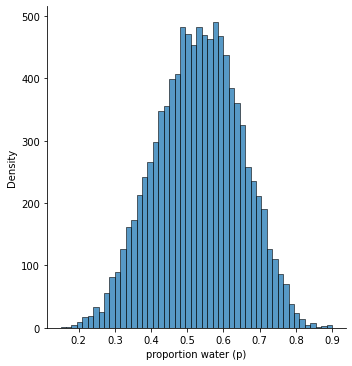

In [10]:
# Medium

# 3M1
samples = sample_binomial(n=15, k=8, n_steps=1000, n_samples=10000)
ax = sns.displot(samples)
ax.set(xlabel="proportion water (p)", ylabel="Density");

In [11]:
# 3M2

stats.hpdi(samples, prob=0.9)

tensor([0.3353, 0.7197])

Execution took 2.1211700439453125 seconds


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


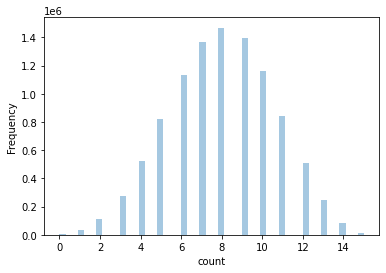

In [12]:
# 3M3

start = time.time()
preds = posterior_predictive_binomial(n=15, posterior=samples, n_samples=1000)
duration = time.time() - start
print(f"Execution took {duration} seconds")
ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

In [13]:
sum(preds == 8).double().mean() / 1000

tensor(0.1469, dtype=torch.float64)

tensor(0.1778, dtype=torch.float64)

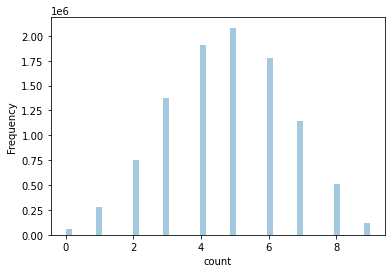

In [14]:
# 3M4

preds = posterior_predictive_binomial(n=9, posterior=samples, n_samples=1000)
ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

sum(preds == 6).double().mean() / 1000

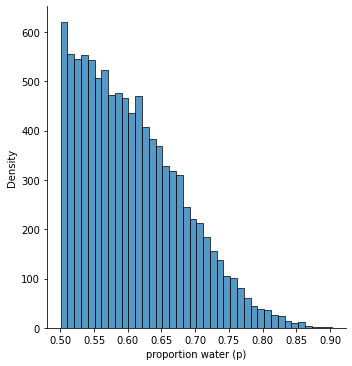

In [15]:
# 3M5

p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.cat((torch.tensor(0.).repeat(500), torch.tensor(1.).repeat(500)), -1)
likelihood = dist.Binomial(
    total_count=15,
    probs=p_grid
).log_prob(torch.tensor(8.)).exp()
posterior = likelihood * prior
posterior = posterior / sum(posterior)
samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

ax = sns.displot(samples)
ax.set(xlabel="proportion water (p)", ylabel="Density");

In [16]:
stats.hpdi(samples, prob=0.9)

tensor([0.5005, 0.7137])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


tensor(0.1569, dtype=torch.float64)

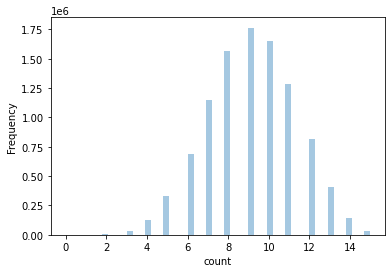

In [17]:
preds = posterior_predictive_binomial(n=15, posterior=samples, n_samples=1000)
ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

sum(preds == 8).double().mean() / 1000

tensor(0.2319, dtype=torch.float64)

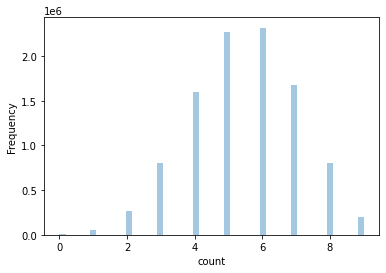

In [18]:
preds = posterior_predictive_binomial(n=9, posterior=samples, n_samples=1000)
ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

sum(preds == 6).double().mean() / 1000

In [19]:
# 3M6

# ???

In [20]:
# Hard

# 3H1

birth1 = torch.tensor([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,1,0,1,1,1,0,1,1,1,1])
birth2 = torch.tensor([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,0,0,0,1,1,1,0,0,0,0])

In [21]:
p_grid = torch.linspace(start=0, end=1, steps=1000)
prior = torch.tensor(1.).repeat(1000)
likelihood = dist.Binomial(
    total_count=len(birth1) + len(birth2),
    probs=p_grid,
).log_prob((torch.sum(birth1) + torch.sum(birth2)).float()).exp()

posterior = likelihood * prior
posterior = posterior / sum(posterior)

print(p_grid[torch.argmax(posterior)])

tensor(0.5546)


tensor([0.5305, 0.5766])
tensor([0.5015, 0.6116])
tensor([0.4815, 0.6306])


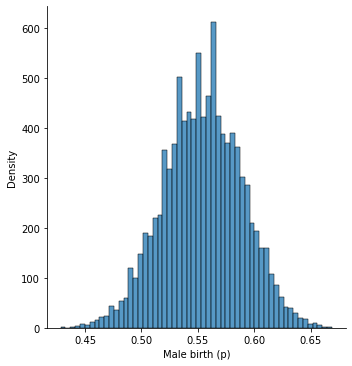

In [22]:
# 3H2

samples = dist.Empirical(p_grid, posterior.log()).sample(torch.Size([int(1e4)]))

ax = sns.displot(samples)
ax.set(xlabel="Male birth (p)", ylabel="Density");

print(stats.hpdi(samples, prob=0.5))
print(stats.hpdi(samples, prob=0.89))
print(stats.hpdi(samples, prob=0.97))

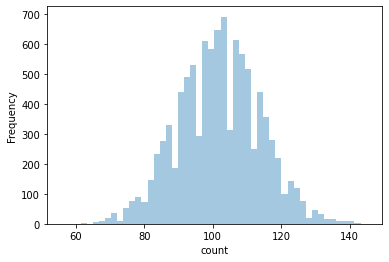

In [34]:
# 3H3

preds = posterior_predictive_binomial(200, samples, float(1))

ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

# Does not look like there is a 'central/likely' outcome from the distribution.

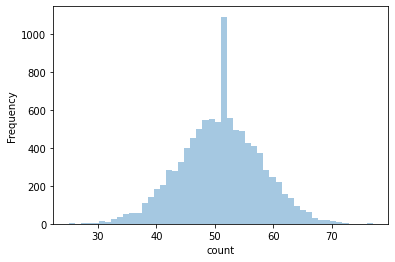

In [36]:
# 3H4

posterior_predictions = dist.Binomial(
    total_count=100,
    probs=samples
).sample(torch.Size([int(1)])).long()

ax = sns.distplot(posterior_predictions, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

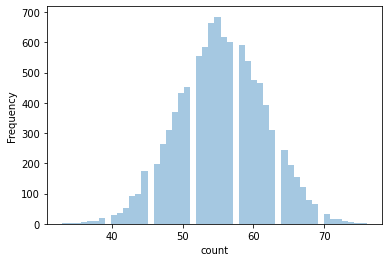

In [26]:
samples = sample_binomial(n=len(birth1), k=float(sum(birth1)), n_steps=1000, n_samples=10000)
preds = posterior_predictive_binomial(n=100, posterior=samples, n_samples=1)

ax = sns.distplot(posterior_predictions, kde=False)
ax.set(xlabel="count", ylabel="Frequency");

In [27]:
# 3H5

first_born_girls = torch.sum(torch.abs(1 - birth1))
print(first_born_girls)

boys_after_girls = torch.sum(torch.abs(1 - birth1) * birth2)
print(boys_after_girls)

tensor(49)
tensor(39)


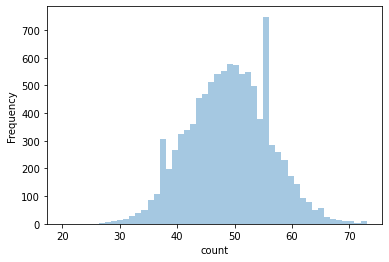

In [32]:
first_girls = sample_binomial(100, 49, int(1e3), int(1e4))
preds = posterior_predictive_binomial(n=100, posterior=first_girls, n_samples=1)

ax = sns.distplot(preds, kde=False)
ax.set(xlabel="count", ylabel="Frequency");